# Trenches on CNN-Ensemble

In [1]:
%cd ../gendist/experiments
%load_ext autoreload
%autoreload 2

/home/gerardoduran/documents/shift-happens/gendist/experiments


In [2]:
import re
import os
import jax
import optax
import gendist
import pickle
import torchvision
import jax.numpy as jnp
import numpy as np
import mnist_rotation_meta as metaexp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from jax.flatten_util import ravel_pytree

In [3]:
import os
from loguru import logger
from datetime import datetime

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
%config InlineBackend.figure_format = "retina"

In [6]:
ls ../../outputs/cnn-rotation/output

cnn-00.pkl  cnn-02.pkl  cnn-04.pkl  cnn-06.pkl  cnn-08.pkl
cnn-01.pkl  cnn-03.pkl  cnn-05.pkl  cnn-07.pkl  cnn-09.pkl


In [7]:
path_experiment = os.path.join("..", "..", "outputs", "cnn-rotation-v2")
filename_data_model = os.path.join(path_experiment, "output", "cnn-00.pkl")
filename_meta_model = os.path.join(path_experiment, "output", "meta-model-result.pkl")

In [8]:
output = metaexp.load_train_combo(filename_data_model)
target_params_single = output["params"]

In [9]:
path_outputs = os.path.join(path_experiment, "output")
files_model = sorted(os.listdir(path_outputs))
target_params = jnp.zeros((len(files_model), *target_params_single.shape))
target_params.shape

(10, 150, 61706)

In [10]:
for i, file in enumerate(files_model):
    path_file = os.path.join(path_outputs, file)
    output = metaexp.load_train_combo(path_file)
    target_params_single = output["params"]
    target_params = target_params.at[i, ...].set(target_params_single)
fn_reconstruct_params = output["fn_reconstruct"]

In [11]:
list_configs = output["configs"]
configs = jnp.array([v["angle"] for v in list_configs])
configs_all = configs * jnp.ones((10, 1))
configs_all = configs_all.ravel()

In [26]:
*_, n_full = target_params.shape

In [ ]:
n_components = 2
tsnse = TSNE(n_components=n_components, init="pca", random_state=314)
projected_params = tsnse.fit_transform(target_params.reshape(1500, -1))

plt.scatter(*projected_params.T, c=configs_all, cmap="twilight")

In [33]:
n_classes = 10
n_train_subset = 6_000
n_configs = len(configs)

key = jax.random.PRNGKey(314)
key, key_subset = jax.random.split(key)
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
X_train = np.array(mnist_train.data) / 255
X_train = metaexp.configure_covariates(key_subset, metaexp.processing_class, X_train, list_configs, n_train_subset)

n_train, *elem_dims = X_train.shape

tcmalloc: large alloc 5644804096 bytes == 0x5562c7b2e000 @  0x7f2444c82680 0x7f2444ca3824 0x7f24233ce1ed 0x7f24233ce267 0x7f2423410c1b 0x7f2423410ed8 0x7f24234c2177 0x7f24234c3dec 0x7f2423609652 0x5561ec681e88 0x5561ec8035d8 0x7f24234caff7 0x5561ec76f520 0x5561ec7aa568 0x5561ec7648c3 0x5561ec6dc1ca 0x5561ec763b32 0x5561ec813ddc 0x5561ec764b5b 0x5561ec8498fe 0x5561ec742581 0x5561ec6dc3be 0x5561ec754d34 0x5561ec7ae3ff 0x5561ec754d34 0x5561ec7ae3ff 0x5561ec754d34 0x5561ec75e0a3 0x5561ec6dc1a4 0x5561ec7648c3 0x5561ec6dc3be
tcmalloc: large alloc 2822406144 bytes == 0x5564b75d8000 @  0x7f2444c82680 0x7f2444ca3824 0x7f24233ce1ed 0x7f24233ce267 0x7f2423410c1b 0x7f24234adb5e 0x7f24234ae37a 0x7f24234ae5ae 0x5561ec723e64 0x5561ec71d7e4 0x7f24233fda74 0x5561ec723e88 0x5561ec71de4f 0x5561ec7a9937 0x5561ec763b32 0x5561ec764697 0x5561ec6dbf00 0x5561ec7648c3 0x5561ec6dc1a4 0x5561ec763b32 0x5561ec764697 0x5561ec75460a 0x5561ec7549d5 0x5561ec71de4f 0x5561ec7a9937 0x5561ec7648c3 0x5561ec6dc1ca 0x5561ec76

## PCA projection

In [199]:
n_components = 50
pca = PCA(n_components)
projected_params = pca.fit_transform(target_params.reshape(1500, -1))
projected_params = projected_params.reshape(10, 150, -1)

In [41]:
alpha = 0.0005
n_epochs = 200
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
meta_model = gendist.models.MLPWeightsV1(n_components)
trainer = gendist.training.TrainingMeta(meta_model, lossfn, tx)

meta_output = trainer.fit(key, X_train, projected_params, n_epochs, batch_size)

  0%|          | 0/200 [00:00<?, ?it/s]

In [44]:
meta_output.keys()

dict_keys(['params', 'losses'])

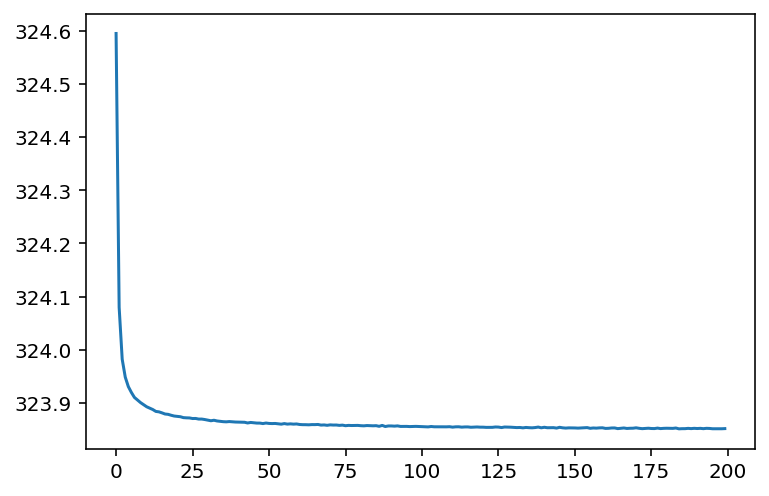

In [45]:
plt.plot(meta_output["losses"])

In [50]:
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

## Testing the model

In [48]:
def test_meta_model(ixs, X_test, fn_processing, configurations, meta_model,
                    data_model, meta_model_params, fn_reconstruct, projector,
                    logger):
    acc_configs_learned = []
    for config in configurations:
        acc_dict = {}
        for ix in ixs:
            yhat_test = metaexp.predict_shifted_dataset(ix, X_test, fn_processing, config,
                                                        meta_model, meta_model_params,
                                                        data_model, projector, fn_reconstruct)
            yhat_test = yhat_test.argmax(axis=1)
            accuracy_learned = (yhat_test == y_test).mean().item()
            acc_dict[ix] = accuracy_learned
        acc_configs_learned.append(acc_dict)
        
        angle = config["angle"]
        logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
        logger_row = f"{angle=:0.4f} | " + logger_row 

        logger.info(logger_row)
    
    return pd.DataFrame(acc_configs_learned)


In [49]:
logger.remove()
now_str = datetime.now().strftime("%Y%m%d%H%M")
# file_log = f"trench_test_{now_str}.log"
file_log = "cnn-test-full.log"

path_logger = os.path.join(path_experiment, "logs", file_log)
logger.add(path_logger, rotation="5mb")
print(file_log)

cnn-test-full.log


In [23]:
data_model = gendist.models.LeNet5(10)

## Autoencoder

Model taken from [Flax's main page on Github](https://github.com/google/flax).

In [21]:
import flax.linen as nn
from typing import Sequence

class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


class AutoEncoder(nn.Module):
  encoder_widths: Sequence[int]
  decoder_widths: Sequence[int]
  input_shape: Sequence[int]

  def setup(self):
    input_dim = np.prod(self.input_shape)
    self.encoder = MLP(self.encoder_widths)
    self.decoder = MLP(self.decoder_widths + (input_dim,))

  def __call__(self, x):
    return self.decode(self.encode(x))

  def encode(self, x):
    assert x.shape[1:] == self.input_shape
    return self.encoder(jnp.reshape(x, (x.shape[0], -1)))

  def decode(self, z):
    z = self.decoder(z)
    x = z#nn.sigmoid(z)
    x = jnp.reshape(x, (x.shape[0],) + self.input_shape)
    return x

In [27]:
n_components = 50
model = AutoEncoder(encoder_widths=[100, 50, n_components],
                    decoder_widths=[50, 50, 100],
                    input_shape=(n_full,))

key = jax.random.PRNGKey(271)
batch = jnp.ones((1, n_full))
proj_weights = model.init(key, batch)


format(len(ravel_pytree(proj_weights)[0]), ",")

'12,420,806'

In [28]:
alpha = 0.0005
tx = optax.adam(learning_rate=alpha)
train_config = gendist.training.TrainingBase(model, lambda x, _: x,
                              gendist.training.make_multi_output_loss_func, tx)

weights_train = target_params.reshape(1500, -1)

train_proj_output = train_config.fit(key, weights_train, weights_train, {}, 5000, 1500)

  0%|          | 0/5000 [00:00<?, ?it/s]

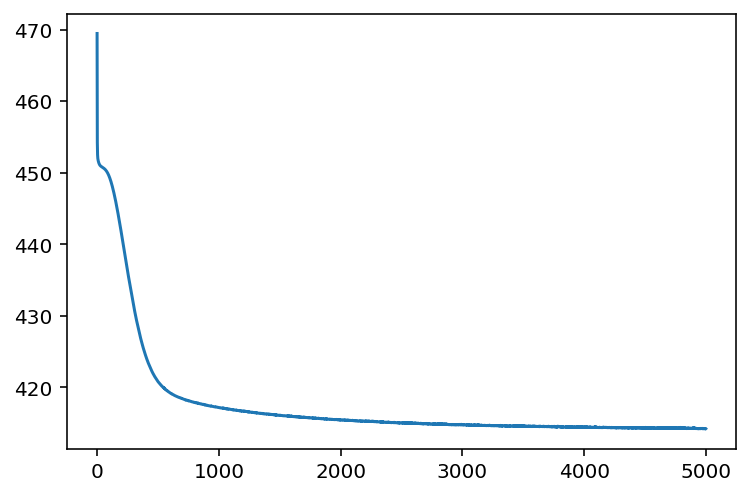

In [29]:
plt.plot(train_proj_output["losses"])

In [30]:
projected_params = model.apply(train_proj_output["params"], weights_train, method=model.encode)

In [ ]:
alpha = 0.0005
n_epochs = 200
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
meta_model = gendist.models.MLPWeightsV1(n_components)
trainer = gendist.training.TrainingMeta(meta_model, lossfn, tx)

meta_output = trainer.fit(key, X_train, projected_params.reshape(10, 150, -1), n_epochs, batch_size)

  0%|          | 0/200 [00:00<?, ?it/s]

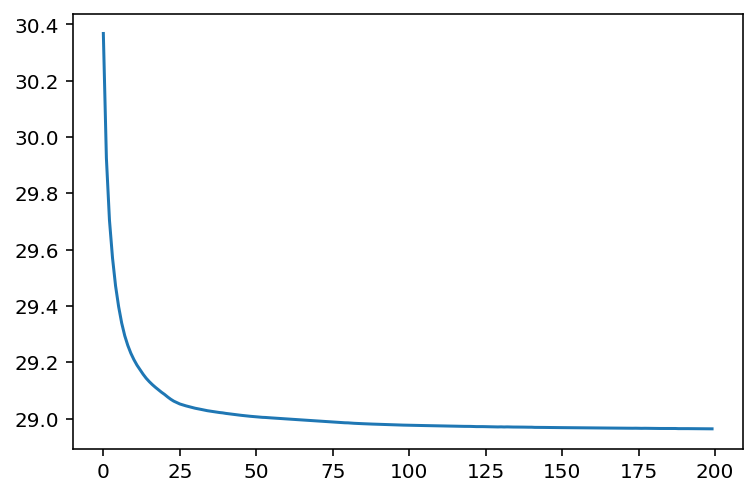

In [37]:
plt.plot(meta_output["losses"])

In [40]:
logger.remove()
now_str = datetime.now().strftime("%Y%m%d%H%M")
# file_log = f"trench_test_{now_str}.log"
file_log = "cnn-test-autoencoder-v2.log"

path_logger = os.path.join(path_experiment, "logs", file_log)
logger.add(path_logger, rotation="5mb")
print(file_log)

cnn-test-autoencoder-v2.log


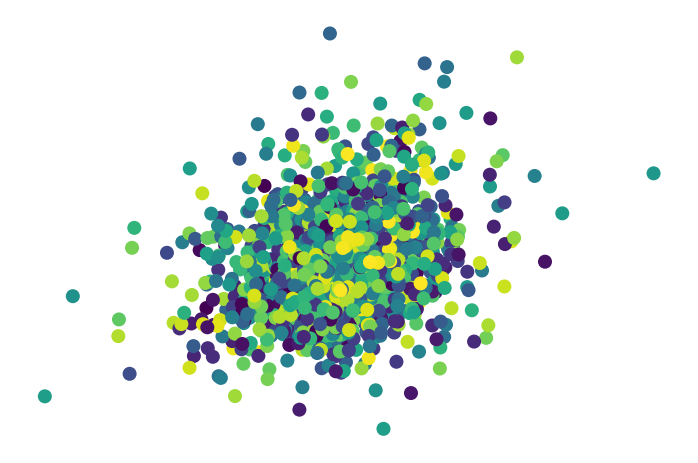

In [42]:
plt.scatter(*projected_params[:, :2].T, c=configs_all, cmap="viridis")
plt.axis("off")
plt.savefig("weights-autoencoder.pdf")

In [43]:
model.apply(train_proj_output["params"], jnp.ones((1,50)), method=model.decode).shape

(1, 61706)

In [44]:
class Proj:
    def __init__(self, model, params):
        self.model = model
        self.params = params
    
    def inverse_transform(self, w_subspace):
        inverse_projection = self.model.apply(self.params, w_subspace[None, :], method=model.decode)
        return inverse_projection.ravel()
    
projector = Proj(model, train_proj_output["params"])

In [45]:
projector.inverse_transform(jnp.ones(50))

DeviceArray([ 0.1834426 , -0.26819754,  0.17294721, ...,  0.2893134 ,
              0.4578624 , -0.04008021], dtype=float32)

In [ ]:
ixs = range(4)
acc_full = test_meta_model(ixs, X_test, metaexp.processing_class, list_configs, meta_model,
                           data_model, meta_output["params"], fn_reconstruct_params, projector, logger)

https://symbolize.stripped_domain/r/?trace=5561ec73fddb,7f2444af83bf,5561ec96b11f&map= 
*** SIGTERM received by PID 1517789 (TID 1517789) on cpu 90 from PID 1492728; stack trace: ***
PC: @     0x5561ec73fddb  (unknown)  insertdict
    @     0x7f243435e7fa        992  (unknown)
    @     0x7f2444af83c0  481751440  (unknown)
    @     0x5561ec96b120  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=5561ec73fddb,7f243435e7f9,7f2444af83bf,5561ec96b11f&map=7a511a57244151c993b16b37978e7ed7:7f2425986000-7f24346c8d50 
E0330 15:15:50.231836 1517789 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0330 15:15:50.262876 1517789 process_state.cc:770] RAW: Raising signal 15 with default behavior
https://symbolize.stripped_domain/r/?trace=7f2444af6a65,7f2444af83bf&map= 
*** SIGTERM received by PID 1519937 (TID 1519937) on cpu 31 from PID 1492728; stack trace: ***
PC: @     0x7f2444af6a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f243435e7fa        992  (unk